### Kaggle Credit Card Fraud Dataset

Taking the algorithms for a spin with the Credit Card Fraud Dataset. The initial modeling has shown a great promise, however I am very sceptical about the 99% accuracy on the test set. Why? Because this dataset is incredibly imbalanced, and what we care about most here are the fraudulent transactions. I am particularly interested if there is an option to set the class weights, so that the deep learning model focuses more on the class of interest (in this case 1 -> fraudulent transaction).


I am going to start this off with a simple logistic regression classifier, which will serve as a baseline model for more complicated architectures, namely deep learning. There is one problem however, MXNet does not have an option to set the class weights, when the dataset is imbalanced.

#### 1. Importing libraries and data

In [4]:
import pandas as pd
from mxnet import autograd, np, npx, init, gluon, metric
from mxnet.gluon import nn
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, log_loss

import matplotlib.pyplot as plt
import os
import d2l

npx.set_np()

In [2]:
def plot_ROC(fpr, tpr, thresholds, actuals, scores,  model = None):
    plt.figure(figsize = (10,5))
    plt.plot(fpr, tpr)
    plt.plot([0,1], [0,1], 'k--')
    
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for ' + str(model))
    
    print('Area Under the Curve score:', roc_auc_score(actuals, scores))

In [7]:
data_path = '/Users/januszpolowczyk/Documents/DeepLearn/data'

In [4]:
df = pd.read_csv(data_path + '/creditcard.csv')

In [ ]:
df.head()

In [ ]:
df.info()

Text(0.5, 1.0, 'Barplot of the "Class" variable')

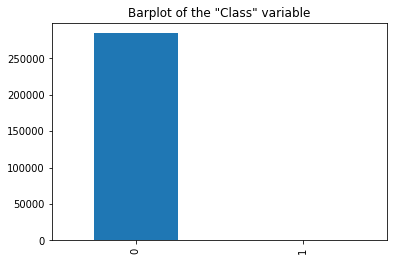

In [5]:
df['Class'].value_counts().plot(kind = 'bar')
plt.title('Barplot of the "Class" variable')

In [6]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [7]:
corr = pd.DataFrame.corr(df)

In [8]:
logreg = LogisticRegression(max_iter = 1000, 
                            class_weight = 'balanced',
                            solver = 'liblinear')

In [9]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [10]:
X['Amount'] = (X['Amount'] - X['Amount'].mean()) / X['Amount'].std()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,
                                                   stratify = y)

In [12]:
k_folds = StratifiedKFold(n_splits = 5, shuffle = True)

In [13]:
training_scores = []
cv_scores = []
predictionsBasedOnKFolds = pd.DataFrame(data = [], index = y_train.index, columns = [0,1])
model = logreg

for train_index, cv_index in k_folds.split(np.zeros(len(X_train)),
                                           y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index, :], X_train.iloc[cv_index, :]
    
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    
    model.fit(X_train_fold, y_train_fold)
    loglossTraining = log_loss(y_train_fold, model.predict_proba(X_train_fold)[:, 1])
    training_scores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index, :] = model.predict_proba(X_cv_fold)
    loglossCV = log_loss(y_cv_fold,
                        predictionsBasedOnKFolds.loc[X_cv_fold.index, 1])
    cv_scores.append(loglossCV)
    
    print('Training log loss:', loglossTraining)

Training log loss: 0.11332951292447155
Training log loss: 0.10406673197958144
Training log loss: 0.11888014810987482
Training log loss: 0.11967181593544675
Training log loss: 0.1182065563850036


In [14]:
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [15]:
y_preds = cross_val_predict(logreg, X_train, y_train, cv = 5)

In [16]:
fpr, tpr, threshold = roc_curve(y_train, y_preds)

Area Under the Curve score: 0.9374604017757899


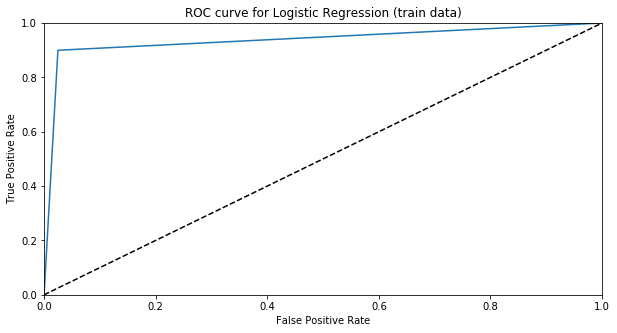

In [17]:
plot_ROC(fpr, tpr, threshold, y_train, y_preds, model = 'Logistic Regression (train data)')

In [18]:
y_test_preds = cross_val_predict(logreg, X_test, y_test, cv = 5)

In [19]:
fpr, tpr, threshold = roc_curve(y_test, y_test_preds)

Area Under the Curve score: 0.9385223723929299


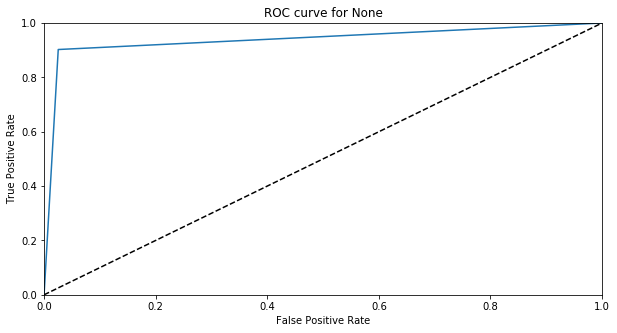

In [20]:
plot_ROC(fpr, tpr, threshold, y_test, y_test_preds)

#### 2. Data transformation + conversion to `NDArray` type

In [8]:
df = pd.read_csv(data_path + '/creditcard.csv')

In [9]:
df['Amount'] = (df['Amount'] - df['Amount'].mean()) / df['Amount'].std()

In [10]:
time = df['Time']
df.drop('Time', axis = 1, inplace = True)

In [11]:
X_train, y_train = df.iloc[:int(len(df) * 0.75), :-1], df.iloc[:int(len(df) * 0.75), -1]
X_test, y_test = df.iloc[int(len(df) * 0.75):, :-1], df.iloc[int(len(df) * 0.75):, -1]


X_train, y_train = np.array(X_train, dtype = np.float32), np.array(y_train)
X_test, y_test = np.array(X_test, dtype = np.float32), np.array(y_test)

y_train, y_test = y_train.reshape(-1,1), y_test.reshape(-1,1)

In [12]:
def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(512, activation='relu'),
            nn.Dropout(0.3),
            nn.Dense(256, activation='relu'),
            nn.Dropout(0.2),
            nn.Dense(2))
    net.initialize()
    return net

In [13]:
loss = gluon.loss.SoftmaxCrossEntropyLoss()

In [14]:
optim = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.03})

NameError: name 'net' is not defined

In [15]:
def load_array(features, labels, batch_size):
    data = gluon.data.ArrayDataset(features, labels)
    return gluon.data.DataLoader(data, batch_size)

In [16]:
train_iter = load_array(X_train, y_train, 256)
test_iter = load_array(X_test, y_test, 256)

In [27]:
def train(net, X_train, y_train, epochs, learning_rate,
         weight_decay, batch_size):
    train_iter = load_array(X_train, y_train, batch_size)
    optim = gluon.Trainer(net.collect_params(), 
                          'sgd', {'learning_rate': learning_rate, 'wd': weight_decay})
    net.initialize()
    for epoch in range(epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            optim.step(batch_size)
        avg_loss = loss(net(X_train), y_train).mean().asnumpy()
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, Loss: {avg_loss}")
    return avg_loss

In [29]:
def k_fold_cross_validation(k,epochs, X_train, y_train, learning_rate,
                           weight_decay, batch_size):
    assert k > 1
    fold_size = X_train.shape[0] // k
    
    train_loss_sum = 0.0
    test_loss_sum = 0.0
    for test_idx in range(k):
        X_val_test = X_train[test_idx * fold_size: (test_idx + 1) * fold_size, :]
        y_val_test = y_train[test_idx * fold_size: (test_idx + 1) * fold_size]
        val_train_defined = False
        
        for i in range(k):
            if i != test_idx:
                X_cur_fold = X_train[i * fold_size: (i + 1) * fold_size, :]
                y_cur_fold = y_train[i * fold_size: (i + 1) * fold_size]
                if not val_train_defined:
                    X_val_train = X_cur_fold
                    y_val_train = y_cur_fold
                    val_train_defined = True
                else:
                    X_val_train = np.concatenate([X_val_train, X_cur_fold], axis = 0)
                    y_val_train = np.concatenate([y_val_train, y_cur_fold], axis = 0)
                    
        net = get_net()
        train_loss = train(net, X_val_train, y_val_train, epochs, learning_rate, weight_decay, batch_size)
        train_loss_sum += train_loss
        test_loss = loss(net(X_val_test), y_val_test).mean().asnumpy()
        test_loss_sum += test_loss
    return train_loss_sum / k, test_loss_sum / k

In [30]:
k = 5
epochs = 50
batch_size = 256
learning_rate = 0.03
weight_decay = 0

In [31]:
train_loss, test_loss = k_fold_cross_validation(k, epochs, X_train, y_train, learning_rate, weight_decay,
                                               batch_size)

/Users/januszpolowczyk/Documents/DeepLearn/env/lib/python3.7/site-packages/mxnet/gluon/parameter.py:887: UserWarning: Parameter 'dense3_bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/Users/januszpolowczyk/Documents/DeepLearn/env/lib/python3.7/site-packages/mxnet/gluon/parameter.py:887: UserWarning: Parameter 'dense4_bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/Users/januszpolowczyk/Documents/DeepLearn/env/lib/python3.7/site-packages/mxnet/gluon/parameter.py:887: UserWarning: Parameter 'dense5_bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)


Epoch: 0, Loss: 0.009052545763552189
Epoch: 10, Loss: 0.002934892661869526
Epoch: 20, Loss: 0.002655492629855871
Epoch: 30, Loss: 0.00250849942676723
Epoch: 40, Loss: 0.0023960876278579235


/Users/januszpolowczyk/Documents/DeepLearn/env/lib/python3.7/site-packages/mxnet/gluon/parameter.py:887: UserWarning: Parameter 'dense6_bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/Users/januszpolowczyk/Documents/DeepLearn/env/lib/python3.7/site-packages/mxnet/gluon/parameter.py:887: UserWarning: Parameter 'dense7_bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/Users/januszpolowczyk/Documents/DeepLearn/env/lib/python3.7/site-packages/mxnet/gluon/parameter.py:887: UserWarning: Parameter 'dense8_bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)


Epoch: 0, Loss: 0.007936914451420307
Epoch: 10, Loss: 0.003467370755970478
Epoch: 20, Loss: 0.0030649586115032434
Epoch: 30, Loss: 0.002825286937877536
Epoch: 40, Loss: 0.002635710407048464


/Users/januszpolowczyk/Documents/DeepLearn/env/lib/python3.7/site-packages/mxnet/gluon/parameter.py:887: UserWarning: Parameter 'dense9_bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/Users/januszpolowczyk/Documents/DeepLearn/env/lib/python3.7/site-packages/mxnet/gluon/parameter.py:887: UserWarning: Parameter 'dense10_bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/Users/januszpolowczyk/Documents/DeepLearn/env/lib/python3.7/site-packages/mxnet/gluon/parameter.py:887: UserWarning: Parameter 'dense11_bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)


Epoch: 0, Loss: 0.006926803849637508
Epoch: 10, Loss: 0.0035186626482754946
Epoch: 20, Loss: 0.0031058667227625847
Epoch: 30, Loss: 0.0028981640934944153
Epoch: 40, Loss: 0.0027301348745822906


/Users/januszpolowczyk/Documents/DeepLearn/env/lib/python3.7/site-packages/mxnet/gluon/parameter.py:887: UserWarning: Parameter 'dense12_bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/Users/januszpolowczyk/Documents/DeepLearn/env/lib/python3.7/site-packages/mxnet/gluon/parameter.py:887: UserWarning: Parameter 'dense13_bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/Users/januszpolowczyk/Documents/DeepLearn/env/lib/python3.7/site-packages/mxnet/gluon/parameter.py:887: UserWarning: Parameter 'dense14_bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)


Epoch: 0, Loss: 0.00900680385529995
Epoch: 10, Loss: 0.003591276938095689
Epoch: 20, Loss: 0.0031863560434430838
Epoch: 30, Loss: 0.0029498981311917305
Epoch: 40, Loss: 0.002761579118669033


/Users/januszpolowczyk/Documents/DeepLearn/env/lib/python3.7/site-packages/mxnet/gluon/parameter.py:887: UserWarning: Parameter 'dense15_bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/Users/januszpolowczyk/Documents/DeepLearn/env/lib/python3.7/site-packages/mxnet/gluon/parameter.py:887: UserWarning: Parameter 'dense16_bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/Users/januszpolowczyk/Documents/DeepLearn/env/lib/python3.7/site-packages/mxnet/gluon/parameter.py:887: UserWarning: Parameter 'dense17_bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)


Epoch: 0, Loss: 0.0072891744785010815
Epoch: 10, Loss: 0.003811096539720893
Epoch: 20, Loss: 0.003357737557962537
Epoch: 30, Loss: 0.003132013836875558
Epoch: 40, Loss: 0.0029409246053546667


In [ ]:
num_epochs = 50
batch_size = 256

for epoch in range(num_epochs + 1):
    for X, y in train_iter:
        with autograd.record():
            l = loss(net(X), y)
        l.backward()
        optim.step(batch_size)
    train_l = loss(net(X_train), y_train)
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {train_l.mean().asnumpy()}')

Epoch: 0, Loss: 0.006574287544935942


In [21]:
preds = net(X_test)
preds = np.array(preds.argmax(axis = 1).reshape(-1,1), dtype = np.int64)

In [23]:
np.mean(preds == y_test)

array(0.99956465)